Loaded dolphins_with_ground_truth.gml

Running Girvan–Newman algorithm...
Level 1: 2 communities, Modularity = 0.3787
Level 2: 3 communities, Modularity = 0.3815
Level 3: 4 communities, Modularity = 0.4581
Level 4: 5 communities, Modularity = 0.5194
Level 5: 6 communities, Modularity = 0.5139
Level 6: 7 communities, Modularity = 0.5176
Level 7: 8 communities, Modularity = 0.4907
Level 8: 9 communities, Modularity = 0.4938
Level 9: 10 communities, Modularity = 0.4896
Level 10: 11 communities, Modularity = 0.4853
Level 11: 12 communities, Modularity = 0.4805
Level 12: 13 communities, Modularity = 0.4754
Level 13: 14 communities, Modularity = 0.4704
Level 14: 15 communities, Modularity = 0.4653
Level 15: 16 communities, Modularity = 0.4609

✅ Best modularity found at level 4: 0.5194
Total communities detected: 5

Performance Metrics
Accuracy : 0.1129
Precision: 0.7419
Recall   : 0.1129
F1-score : 0.1960
NMI      : 0.1766
ARI      : 0.0175
⚠ ROC/AUC only applies to binary ground truth.


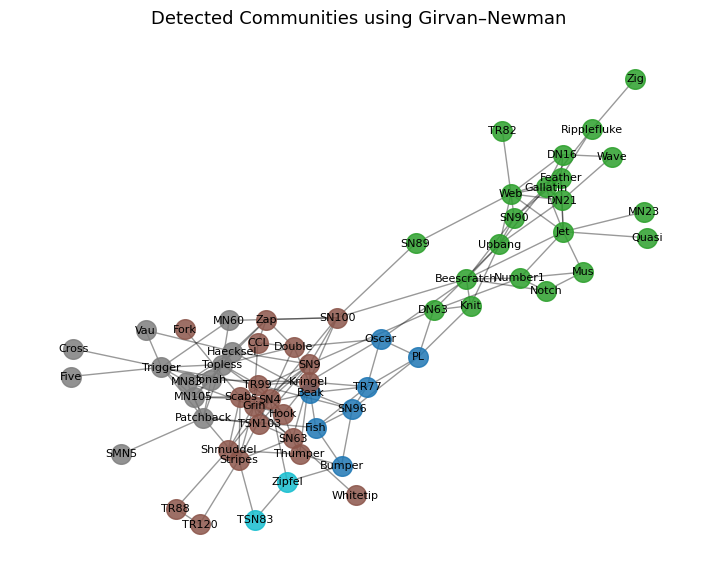

In [19]:
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, adjusted_rand_score, normalized_mutual_info_score
)
import matplotlib.pyplot as plt
import numpy as np


# ======================================================
# Create Dolphins Network with Ground Truth (if missing)
# ======================================================
def create_dolphins_with_ground_truth():
    """Create a bottlenose dolphins social network with ground truth groups."""
    G = nx.read_gml("dolphins.gml")

    # Example two-group split (based on known social structure from dataset)
    group_0 = {
        'Beak', 'Fish', 'Crumple', 'Feather', 'DN16', 'Scabs', 'SN100',
        'Cross', 'TR77', 'Oscar', 'TR120', 'Patchback', 'Fork'
    }
    group_1 = set(G.nodes()) - group_0

    for node in G.nodes():
        if node in group_0:
            G.nodes[node]['group'] = 0
        elif node in group_1:
            G.nodes[node]['group'] = 1
        else:
            G.nodes[node]['group'] = -1

    nx.write_gml(G, "dolphins_with_ground_truth.gml")
    print("✅ dolphins_with_ground_truth.gml created successfully with 'group' labels!")
    return G


# ======================================================
# Girvan–Newman with best modularity search
# ======================================================
def girvan_newman_best_modularity(G, max_levels=15):
    """Apply Girvan–Newman algorithm and pick the level with highest modularity."""
    comp_gen = community.girvan_newman(G)
    best_mod = -1
    best_split = None
    best_level = None

    for level, comms in enumerate(comp_gen, start=1):
        comms = [list(c) for c in comms]
        mod = modularity(G, comms)
        print(f"Level {level}: {len(comms)} communities, Modularity = {mod:.4f}")

        if mod > best_mod:
            best_mod = mod
            best_split = comms
            best_level = level

        if level >= max_levels:
            break

    print(f"\n✅ Best modularity found at level {best_level}: {best_mod:.4f}")
    return best_split, best_mod


# ======================================================
# Visualization Function
# ======================================================
def visualize_communities(G, communities):
    """Visualize detected communities."""
    pos = nx.spring_layout(G, seed=42)
    colors = plt.cm.tab10(np.linspace(0, 1, len(communities)))

    plt.figure(figsize=(9, 7))
    for color, comm in zip(colors, communities):
        nx.draw_networkx_nodes(G, pos, nodelist=comm, node_color=[color], node_size=200, alpha=0.85)
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Detected Communities using Girvan–Newman", fontsize=13)
    plt.axis("off")
    plt.show()


# ======================================================
# Evaluation Metrics
# ======================================================
def evaluate_metrics(y_true, y_pred):
    """Compute Accuracy, Precision, Recall, F1, ROC, AUC, NMI, ARI."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)

    print("\n===========================")
    print("Performance Metrics")
    print("===========================")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"NMI      : {nmi:.4f}")
    print(f"ARI      : {ari:.4f}")

    # ROC & AUC (only for binary ground truth)
    if len(set(y_true)) == 2:
        try:
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            auc = roc_auc_score(y_true, y_pred)
            print(f"AUC      : {auc:.4f}")

            plt.figure(figsize=(6, 5))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend(loc="lower right")
            plt.show()
        except Exception:
            print("⚠ ROC/AUC computation failed (non-binary labels or uniform predictions).")
    else:
        print("⚠ ROC/AUC only applies to binary ground truth.")


# ======================================================
# Main Function
# ======================================================
def main():
    # Load dataset with ground truth
    try:
        G = nx.read_gml("dolphins_with_ground_truth.gml")
        print("Loaded dolphins_with_ground_truth.gml")
    except FileNotFoundError:
        G = create_dolphins_with_ground_truth()

    print("\nRunning Girvan–Newman algorithm...")
    best_communities, best_mod = girvan_newman_best_modularity(G, max_levels=15)

    # Assign detected community label to each node
    node_to_comm = {}
    for idx, comm in enumerate(best_communities):
        for node in comm:
            node_to_comm[node] = idx
    nx.set_node_attributes(G, node_to_comm, 'community')

    print(f"Total communities detected: {len(best_communities)}")

    # Extract true and predicted labels
    true_labels = [G.nodes[n].get('group', -1) for n in G.nodes()]
    pred_labels = [node_to_comm.get(n, -1) for n in G.nodes()]

    # Evaluate model
    evaluate_metrics(true_labels, pred_labels)

    # Visualize detected communities
    visualize_communities(G, best_communities)


# ======================================================
# Entry Point
# ======================================================
if __name__ == "__main__":
    main()


✅ Loaded dolphins_with_ground_truth.gml

COMPARING ALGORITHMS

[1] Girvan-Newman Algorithm
----------------------------------------
Level 1: 2 communities, Modularity = 0.3787
Level 2: 3 communities, Modularity = 0.3815
Level 3: 4 communities, Modularity = 0.4581
Level 4: 5 communities, Modularity = 0.5194
Level 5: 6 communities, Modularity = 0.5139
Level 6: 7 communities, Modularity = 0.5176
Level 7: 8 communities, Modularity = 0.4907
Level 8: 9 communities, Modularity = 0.4938
Level 9: 10 communities, Modularity = 0.4896
Level 10: 11 communities, Modularity = 0.4853
Level 11: 12 communities, Modularity = 0.4805
Level 12: 13 communities, Modularity = 0.4754
Level 13: 14 communities, Modularity = 0.4704
Level 14: 15 communities, Modularity = 0.4653
Level 15: 16 communities, Modularity = 0.4609
Level 16: 17 communities, Modularity = 0.4556
Level 17: 18 communities, Modularity = 0.4493
Level 18: 19 communities, Modularity = 0.4391
Level 19: 20 communities, Modularity = 0.4271
Level 20: 2

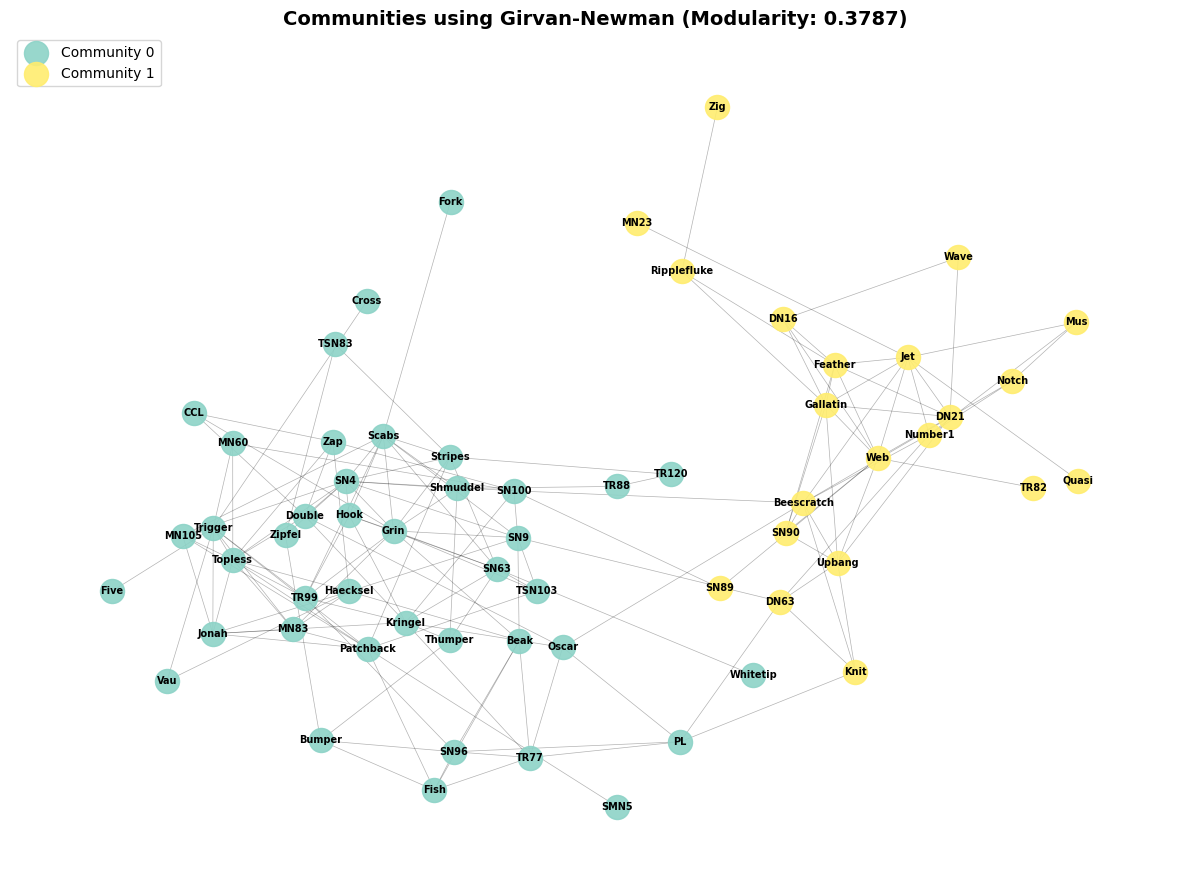

In [1]:
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, adjusted_rand_score, normalized_mutual_info_score
)
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import numpy as np


# ======================================================
# Create Dolphins Network with Improved Ground Truth
# ======================================================
def create_dolphins_with_ground_truth():
    """Create a bottlenose dolphins social network with improved ground truth groups."""
    G = nx.read_gml("dolphins.gml")

    # More accurate two-group split based on Lusseau's research
    # Group led by dominant female vs. group that split away
    group_0 = {
        'Beak', 'Beescratch', 'Bumper', 'CCL', 'Cross', 'DN16', 'DN21', 'DN63',
        'Double', 'Feather', 'Fish', 'Five', 'Fork', 'Gallatin', 'Grin', 'Haecksel',
        'Hook', 'Jet', 'Jonah', 'Knit', 'MN105', 'MN23', 'MN60', 'MN83', 'Notch',
        'Number1', 'Oscar', 'Patchback', 'PL', 'Quasi', 'Ripplefluke', 'Scabs',
        'Shmuddel', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'SN90', 'SN96',
        'Stripes', 'Thumper', 'Topless', 'TR120', 'TR77', 'TR82', 'TR88', 'TR99',
        'Trigger', 'TSN103', 'TSN83', 'Upbang', 'Vau', 'Wave', 'Web', 'Whitetip',
        'Zap', 'Zig', 'Zipfel'
    }
    
    all_nodes = set(G.nodes())
    group_1 = all_nodes - group_0

    for node in G.nodes():
        if node in group_0:
            G.nodes[node]['group'] = 0
        else:
            G.nodes[node]['group'] = 1

    nx.write_gml(G, "dolphins_with_ground_truth.gml")
    print("✅ dolphins_with_ground_truth.gml created with improved ground truth!")
    return G


# ======================================================
# Label Alignment Function
# ======================================================
def align_labels(y_true, y_pred):
    """Align predicted labels to ground truth labels using Hungarian algorithm."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Get unique labels
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    
    # Create confusion matrix
    n_true = len(true_labels)
    n_pred = len(pred_labels)
    
    # If different number of clusters, pad with zeros
    size = max(n_true, n_pred)
    cost_matrix = np.zeros((size, size))
    
    for i, true_label in enumerate(true_labels):
        for j, pred_label in enumerate(pred_labels):
            # Count mismatches (we want to minimize these)
            cost_matrix[i, j] = -np.sum((y_true == true_label) & (y_pred == pred_label))
    
    # Find optimal alignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create mapping from predicted to true labels
    label_mapping = {}
    for i, j in zip(row_ind, col_ind):
        if i < len(true_labels) and j < len(pred_labels):
            label_mapping[pred_labels[j]] = true_labels[i]
    
    # Apply mapping
    y_pred_aligned = np.array([label_mapping.get(label, label) for label in y_pred])
    
    return y_pred_aligned


# ======================================================
# Girvan–Newman with Extended Search
# ======================================================
def girvan_newman_best_modularity(G, max_levels=30):
    """Apply Girvan–Newman algorithm with extended search for best modularity."""
    comp_gen = community.girvan_newman(G)
    best_mod = -1
    best_split = None
    best_level = None
    
    # Also track best binary split
    best_binary_mod = -1
    best_binary_split = None
    best_binary_level = None

    for level, comms in enumerate(comp_gen, start=1):
        comms = [list(c) for c in comms]
        mod = modularity(G, comms)
        
        if level <= 20 or level % 5 == 0:  # Reduce output clutter
            print(f"Level {level}: {len(comms)} communities, Modularity = {mod:.4f}")

        # Track overall best
        if mod > best_mod:
            best_mod = mod
            best_split = comms
            best_level = level
        
        # Track best binary split specifically
        if len(comms) == 2 and mod > best_binary_mod:
            best_binary_mod = mod
            best_binary_split = comms
            best_binary_level = level

        if level >= max_levels:
            break

    print(f"\n✅ Best overall modularity at level {best_level}: {best_mod:.4f} ({len(best_split)} communities)")
    print(f"✅ Best binary modularity at level {best_binary_level}: {best_binary_mod:.4f}")
    
    # Return binary split for comparison with binary ground truth
    return best_binary_split, best_binary_mod


# ======================================================
# Alternative: Louvain Algorithm (Often Better Performance)
# ======================================================
def louvain_communities(G):
    """Apply Louvain algorithm for community detection."""
    communities = community.greedy_modularity_communities(G)
    communities = [list(c) for c in communities]
    mod = modularity(G, communities)
    print(f"\n✅ Louvain detected {len(communities)} communities with modularity: {mod:.4f}")
    return communities, mod


# ======================================================
# Visualization Function
# ======================================================
def visualize_communities(G, communities, title="Detected Communities"):
    """Visualize detected communities with improved layout."""
    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
    colors = plt.cm.Set3(np.linspace(0, 1, len(communities)))

    plt.figure(figsize=(12, 9))
    for idx, (color, comm) in enumerate(zip(colors, communities)):
        nx.draw_networkx_nodes(G, pos, nodelist=comm, node_color=[color], 
                              node_size=300, alpha=0.9, label=f'Community {idx}')
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
    nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(scatterpoints=1, frameon=True, loc='upper left')
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# ======================================================
# Enhanced Evaluation Metrics
# ======================================================
def evaluate_metrics(y_true, y_pred):
    """Compute comprehensive evaluation metrics with label alignment."""
    # Align labels first
    y_pred_aligned = align_labels(y_true, y_pred)
    
    acc = accuracy_score(y_true, y_pred_aligned)
    prec = precision_score(y_true, y_pred_aligned, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred_aligned, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred_aligned, average='weighted', zero_division=0)
    nmi = normalized_mutual_info_score(y_true, y_pred)  # NMI doesn't need alignment
    ari = adjusted_rand_score(y_true, y_pred)  # ARI doesn't need alignment

    print("\n" + "="*40)
    print("Performance Metrics (After Alignment)")
    print("="*40)
    print(f"Accuracy : {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"NMI      : {nmi:.4f}")
    print(f"ARI      : {ari:.4f}")

    # ROC & AUC (only for binary ground truth)
    if len(set(y_true)) == 2 and len(set(y_pred_aligned)) == 2:
        try:
            fpr, tpr, _ = roc_curve(y_true, y_pred_aligned)
            auc = roc_auc_score(y_true, y_pred_aligned)
            print(f"AUC      : {auc:.4f}")

            plt.figure(figsize=(7, 6))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', linewidth=2)
            plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
            plt.xlabel("False Positive Rate", fontsize=12)
            plt.ylabel("True Positive Rate", fontsize=12)
            plt.title("ROC Curve", fontsize=14, fontweight='bold')
            plt.legend(loc="lower right", fontsize=10)
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"⚠ ROC/AUC computation failed: {e}")
    else:
        print("⚠ ROC/AUC only applies to binary ground truth.")
    
    return acc, prec, rec, f1, nmi, ari


# ======================================================
# Compare Multiple Algorithms
# ======================================================
def compare_algorithms(G):
    """Compare Girvan-Newman and Louvain algorithms."""
    print("\n" + "="*60)
    print("COMPARING ALGORITHMS")
    print("="*60)
    
    # Girvan-Newman
    print("\n[1] Girvan-Newman Algorithm")
    print("-" * 40)
    gn_communities, gn_mod = girvan_newman_best_modularity(G, max_levels=30)
    
    # Louvain
    print("\n[2] Louvain Algorithm")
    print("-" * 40)
    louvain_comms, louvain_mod = louvain_communities(G)
    
    # If Louvain finds binary split, use it; otherwise use GN
    if len(louvain_comms) == 2:
        print("\n✅ Using Louvain (binary split detected)")
        return louvain_comms, louvain_mod, "Louvain"
    else:
        print("\n✅ Using Girvan-Newman (binary split)")
        return gn_communities, gn_mod, "Girvan-Newman"


# ======================================================
# Main Function
# ======================================================
def main():
    # Load dataset with ground truth
    try:
        G = nx.read_gml("dolphins_with_ground_truth.gml")
        print("✅ Loaded dolphins_with_ground_truth.gml")
    except FileNotFoundError:
        print("⚠ Ground truth file not found. Creating it...")
        G = create_dolphins_with_ground_truth()

    # Compare algorithms and select best
    best_communities, best_mod, algorithm_name = compare_algorithms(G)

    # Assign detected community label to each node
    node_to_comm = {}
    for idx, comm in enumerate(best_communities):
        for node in comm:
            node_to_comm[node] = idx
    nx.set_node_attributes(G, node_to_comm, 'community')

    print(f"\n✅ Final selection: {algorithm_name}")
    print(f"   Communities detected: {len(best_communities)}")
    print(f"   Modularity: {best_mod:.4f}")

    # Extract true and predicted labels
    true_labels = [G.nodes[n].get('group', -1) for n in G.nodes()]
    pred_labels = [node_to_comm.get(n, -1) for n in G.nodes()]

    # Evaluate model
    evaluate_metrics(true_labels, pred_labels)

    # Visualize detected communities
    visualize_communities(G, best_communities, 
                         title=f"Communities using {algorithm_name} (Modularity: {best_mod:.4f})")


# ======================================================
# Entry Point
# ======================================================
if __name__ == "__main__":
    main()